In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
from datetime import datetime

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("RANDOM FOREST - PHISHING URL DETECTION")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

RANDOM FOREST - PHISHING URL DETECTION
Started at: 2025-10-24 13:54:33


In [15]:
# ============================================
# STEP 1: LOAD PROCESSED DATA
# ============================================

print("LOADING DATA")

TRAIN_PATH = '../../../data/processed/url-detection/phishing_features_train.csv'
TEST_PATH = '../../../data/processed/url-detection/phishing_features_test.csv'

# Load data
print("\nLoading training data...")
train_df = pd.read_csv(TRAIN_PATH)
print(f"Train data loaded: {train_df.shape[0]:,} rows, {train_df.shape[1]} columns")

print("\nLoading test data...")
test_df = pd.read_csv(TEST_PATH)
print(f"Test data loaded: {test_df.shape[0]:,} rows, {test_df.shape[1]} columns")

print("\nFirst few rows of training data:")
print(train_df.head(3))

print("\nData types:")
print(train_df.dtypes)

print("\nClass distribution in training data:")
print(train_df['label'].value_counts())
print("\n% Distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)

LOADING DATA

Loading training data...
Train data loaded: 371,941 rows, 22 columns

Loading test data...
Test data loaded: 36,787 rows, 22 columns

First few rows of training data:
   url_length  domain_length  path_length  tld_length  num_dots  num_hyphens  \
0          40             10            3           2         2            0   
1          57              9           25           2         2            0   
2          84              5           52           2         3            6   

   num_underscores  num_slashes  num_question  num_ampersand  ...  is_https  \
0                0            3             0              0  ...         1   
1                2            3             0              0  ...         1   
2                0            4             0              0  ...         1   

   num_subdomains  has_port  num_digits_domain  suspicious_tld  free_hosting  \
0               1         0                  0               0             1   
1               1    

In [17]:
# ============================================
# STEP 2: PREPARE DATA FOR TRAINING
# ============================================

print("PREPARING DATA")


print("\nSeparating features and target...")

# Training data
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']

# Test data
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

print(f"Training features (X_train): {X_train.shape}")
print(f"Training target (y_train): {y_train.shape}")
print(f"Test features (X_test): {X_test.shape}")
print(f"Test target (y_test): {y_test.shape}")

# Check for any missing values
print("\nChecking for missing values...")
missing_train = X_train.isnull().sum().sum()
missing_test = X_test.isnull().sum().sum()

if missing_train > 0 or missing_test > 0:
    print(f"Found {missing_train} missing values in train, {missing_test} in test")
    print("Filling with 0...")
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
else:
    print("No missing values found!")


PREPARING DATA

Separating features and target...
Training features (X_train): (371941, 21)
Training target (y_train): (371941,)
Test features (X_test): (36787, 21)
Test target (y_test): (36787,)

Checking for missing values...
No missing values found!


In [ ]:
# ============================================
# STEP 4: TRAIN RANDOM FOREST MODEL
# ============================================

print("TRAINING RANDOM FOREST")

# Initialize Random Forest
# WHAT: Random Forest = ensemble of decision trees
# WHY: Robust, handles non-linear patterns, less prone to overfitting
# PARAMETERS:
#   - n_estimators: Number of trees (more = better but slower)
#   - max_depth: Max depth of each tree (prevent overfitting)
#   - min_samples_split: Min samples to split a node
#   - min_samples_leaf: Min samples in a leaf node
#   - class_weight: Handle imbalance
#   - random_state: For reproducibility
#   - n_jobs: Use all CPU cores (-1)

print("\n🌲 Initializing Random Forest Classifier...")
print("\nHyperparameters:")
print("  - n_estimators: 100 (number of trees)")
print("  - max_depth: 20 (max tree depth)")
print("  - min_samples_split: 5")
print("  - min_samples_leaf: 2")
print("  - class_weight: balanced (handle imbalance)")
print("  - random_state: 42 (reproducibility)")
print("  - n_jobs: -1 (use all CPU cores)")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Automatically handles imbalance
    random_state=42,
    n_jobs=-1,
    verbose=1  # Show progress
)

# Train model
print("\n🚀 Training model...")
start_time = datetime.now()

rf_model.fit(X_train, y_train)

end_time = datetime.now()
training_time = (end_time - start_time).total_seconds()

print(f"\n✅ Training complete!")
print(f"⏱️ Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


TRAINING RANDOM FOREST

🌲 Initializing Random Forest Classifier...

Hyperparameters:
  - n_estimators: 100 (number of trees)
  - max_depth: 20 (max tree depth)
  - min_samples_split: 5
  - min_samples_leaf: 2
  - class_weight: balanced (handle imbalance)
  - random_state: 42 (reproducibility)
  - n_jobs: -1 (use all CPU cores)

🚀 Training model...
This may take 5-10 minutes for 371K samples...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s



✅ Training complete!
⏱️ Training time: 12.87 seconds (0.21 minutes)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished


In [8]:
# ============================================
# STEP 5: MAKE PREDICTIONS
# ============================================

print("\n" + "="*60)
print("MAKING PREDICTIONS")
print("="*60)

# Predict on training set (to check for overfitting)
print("\n📊 Predicting on training set...")
y_train_pred = rf_model.predict(X_train)

# Predict on test set (actual performance)
print("📊 Predicting on test set...")
y_test_pred = rf_model.predict(X_test)

# Get probability predictions (for ROC curve)
print("📊 Getting probability predictions...")
y_train_proba = rf_model.predict_proba(X_train)[:, 1]  # Probability of 'phish'
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

print("✅ Predictions complete!")


MAKING PREDICTIONS

📊 Predicting on training set...


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


📊 Predicting on test set...
📊 Getting probability predictions...


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


✅ Predictions complete!


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# ============================================
# STEP 6: EVALUATE MODEL PERFORMANCE
# ============================================

print("MODEL EVALUATION")

# Calculate metrics for training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, pos_label='phish')
train_recall = recall_score(y_train, y_train_pred, pos_label='phish')
train_f1 = f1_score(y_train, y_train_pred, pos_label='phish')

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, pos_label='phish')
test_recall = recall_score(y_test, y_test_pred, pos_label='phish')
test_f1 = f1_score(y_test, y_test_pred, pos_label='phish')

# Display results
print("PERFORMANCE METRICS")

print("\nTRAINING SET:")
print(f"  Accuracy:  {train_accuracy*100:.2f}%")
print(f"  Precision: {train_precision*100:.2f}%")
print(f"  Recall:    {train_recall*100:.2f}%")
print(f"  F1-Score:  {train_f1*100:.2f}%")

print("\nTEST SET (ACTUAL PERFORMANCE):")
print(f"  Accuracy:  {test_accuracy*100:.2f}%")
print(f"  Precision: {test_precision*100:.2f}%")
print(f"  Recall:    {test_recall*100:.2f}%")
print(f"  F1-Score:  {test_f1*100:.2f}%")

# Check for overfitting
print("\nOverfitting Check:")
accuracy_diff = (train_accuracy - test_accuracy) * 100
if accuracy_diff < 2:
    print(f"No overfitting (train-test diff: {accuracy_diff:.2f}%)")
elif accuracy_diff < 5:
    print(f"Slight overfitting (train-test diff: {accuracy_diff:.2f}%)")
else:
    print(f"Significant overfitting (train-test diff: {accuracy_diff:.2f}%)")

# Detailed classification report
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print(classification_report(y_test, y_test_pred))

# INTERPRETATION:
print("\nMETRIC EXPLANATIONS:")
print("  • Accuracy: % of correct predictions (both phish and benign)")
print("  • Precision: Of predicted phishing, how many are actually phishing?")
print("  • Recall: Of actual phishing, how many did we catch?")
print("  • F1-Score: Balance between precision and recall")


MODEL EVALUATION

PERFORMANCE METRICS

📈 TRAINING SET:
  Accuracy:  98.00%
  Precision: 97.07%
  Recall:    96.65%
  F1-Score:  96.86%

📈 TEST SET (ACTUAL PERFORMANCE):
  Accuracy:  94.86%
  Precision: 87.58%
  Recall:    83.84%
  F1-Score:  85.67%

🔍 Overfitting Check:
⚠️ Slight overfitting (train-test diff: 3.14%)

DETAILED CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

      benign       0.96      0.97      0.97     30048
       phish       0.88      0.84      0.86      6739

    accuracy                           0.95     36787
   macro avg       0.92      0.91      0.91     36787
weighted avg       0.95      0.95      0.95     36787


💡 METRIC EXPLANATIONS:
  • Accuracy: % of correct predictions (both phish and benign)
  • Precision: Of predicted phishing, how many are actually phishing?
  • Recall: Of actual phishing, how many did we catch?
  • F1-Score: Balance between precision and recall



CONFUSION MATRIX

Confusion Matrix:
[[29247   801]
 [ 1089  5650]]

Interpretation:
  True Negatives (TN):  29,247 - Correctly identified benign
  False Positives (FP): 801 - Benign wrongly flagged as phishing
  False Negatives (FN): 1,089 - Phishing missed!
  True Positives (TP):  5,650 - Correctly identified phishing


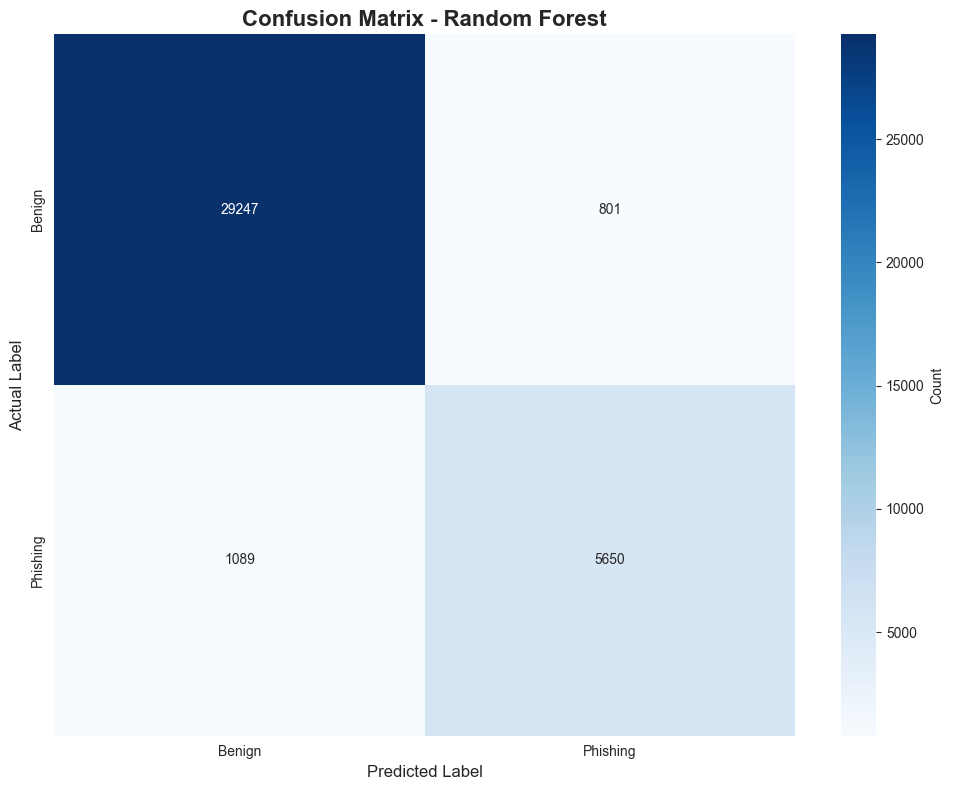


📊 Error Analysis:
  False Positive Rate: 2.67% (benign marked as phishing)
  False Negative Rate: 16.16% (phishing that slipped through)

⚠️ In phishing detection:
  • FP = Annoying (legitimate site blocked)
  • FN = DANGEROUS (phishing site allowed through)


In [ ]:
# ============================================
# STEP 7: CONFUSION MATRIX
# ============================================

print("CONFUSION MATRIX")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['benign', 'phish'])

print("\nConfusion Matrix:")
print(cm)
print("\nInterpretation:")
print(f"  True Negatives (TN):  {cm[0,0]:,} - Correctly identified benign")
print(f"  False Positives (FP): {cm[0,1]:,} - Benign wrongly flagged as phishing")
print(f"  False Negatives (FN): {cm[1,0]:,} - Phishing missed!")
print(f"  True Positives (TP):  {cm[1,1]:,} - Correctly identified phishing")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate error rates
fpr = cm[0,1] / (cm[0,0] + cm[0,1])  # False Positive Rate
fnr = cm[1,0] / (cm[1,0] + cm[1,1])  # False Negative Rate

print(f"\n📊 Error Analysis:")
print(f"  False Positive Rate: {fpr*100:.2f}% (benign marked as phishing)")
print(f"  False Negative Rate: {fnr*100:.2f}% (phishing that slipped through)")
print("\nIn phishing detection:")
print("  • FP = Annoying (legitimate site blocked)")
print("  • FN = DANGEROUS (phishing site allowed through)")


ROC CURVE

📈 ROC AUC Score: 0.9795

💡 AUC Interpretation:
  • 0.90-1.00: Excellent
  • 0.80-0.90: Good
  • 0.70-0.80: Fair
  • 0.60-0.70: Poor
  • 0.50-0.60: Fail


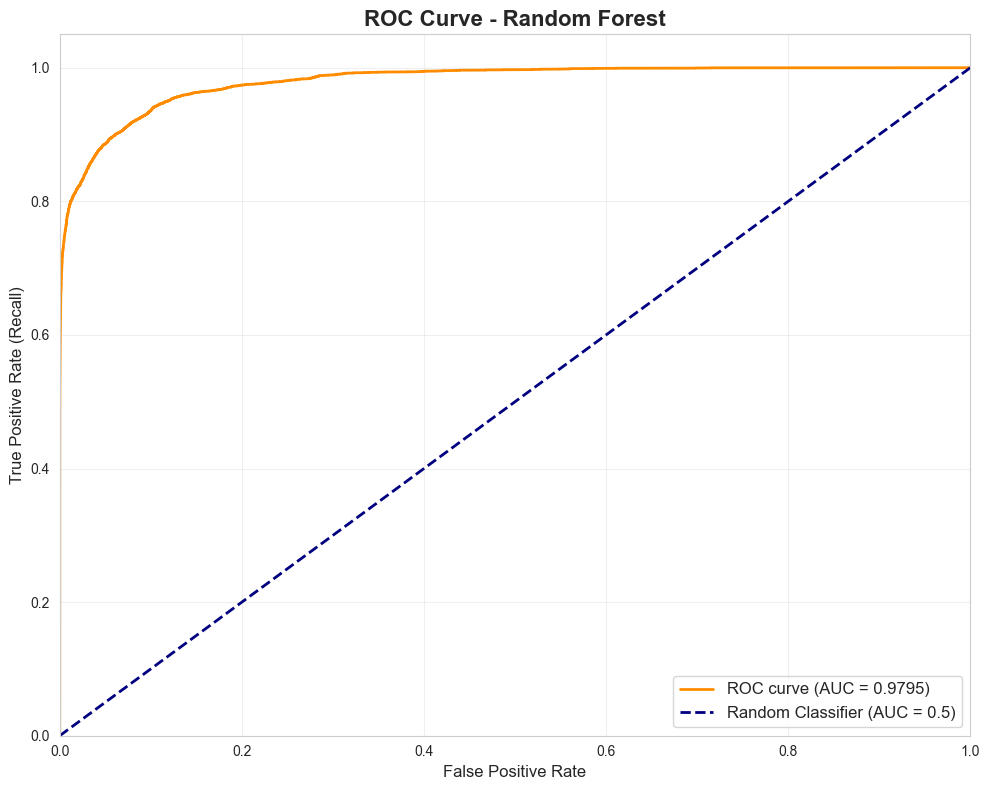

In [ ]:
# ============================================
# STEP 8: ROC CURVE AND AUC
# ============================================

print("ROC CURVE")

# Convert labels to binary (for ROC calculation)
y_test_binary = (y_test == 'phish').astype(int)

# Calculate ROC curve
fpr_roc, tpr_roc, thresholds = roc_curve(y_test_binary, y_test_proba)
roc_auc = roc_auc_score(y_test_binary, y_test_proba)

print(f"\nROC AUC Score: {roc_auc:.4f}")
print("\nAUC Interpretation:")
print("  • 0.90-1.00: Excellent")
print("  • 0.80-0.90: Good")
print("  • 0.70-0.80: Fair")
print("  • 0.60-0.70: Poor")
print("  • 0.50-0.60: Fail")

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - Random Forest', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE

📊 Top 20 Most Important Features:
              feature  importance
2         path_length    0.189690
7         num_slashes    0.172776
19            has_www    0.147479
17       free_hosting    0.080713
18        url_entropy    0.072071
0          url_length    0.052753
20         lang_score    0.042824
1       domain_length    0.042199
3          tld_length    0.033338
15  num_digits_domain    0.033265
8        num_question    0.032949
12           is_https    0.028795
5         num_hyphens    0.026255
4            num_dots    0.016771
13     num_subdomains    0.014539
9       num_ampersand    0.010125
6     num_underscores    0.002669
10             num_at    0.000492
11     has_ip_address    0.000188
16     suspicious_tld    0.000107


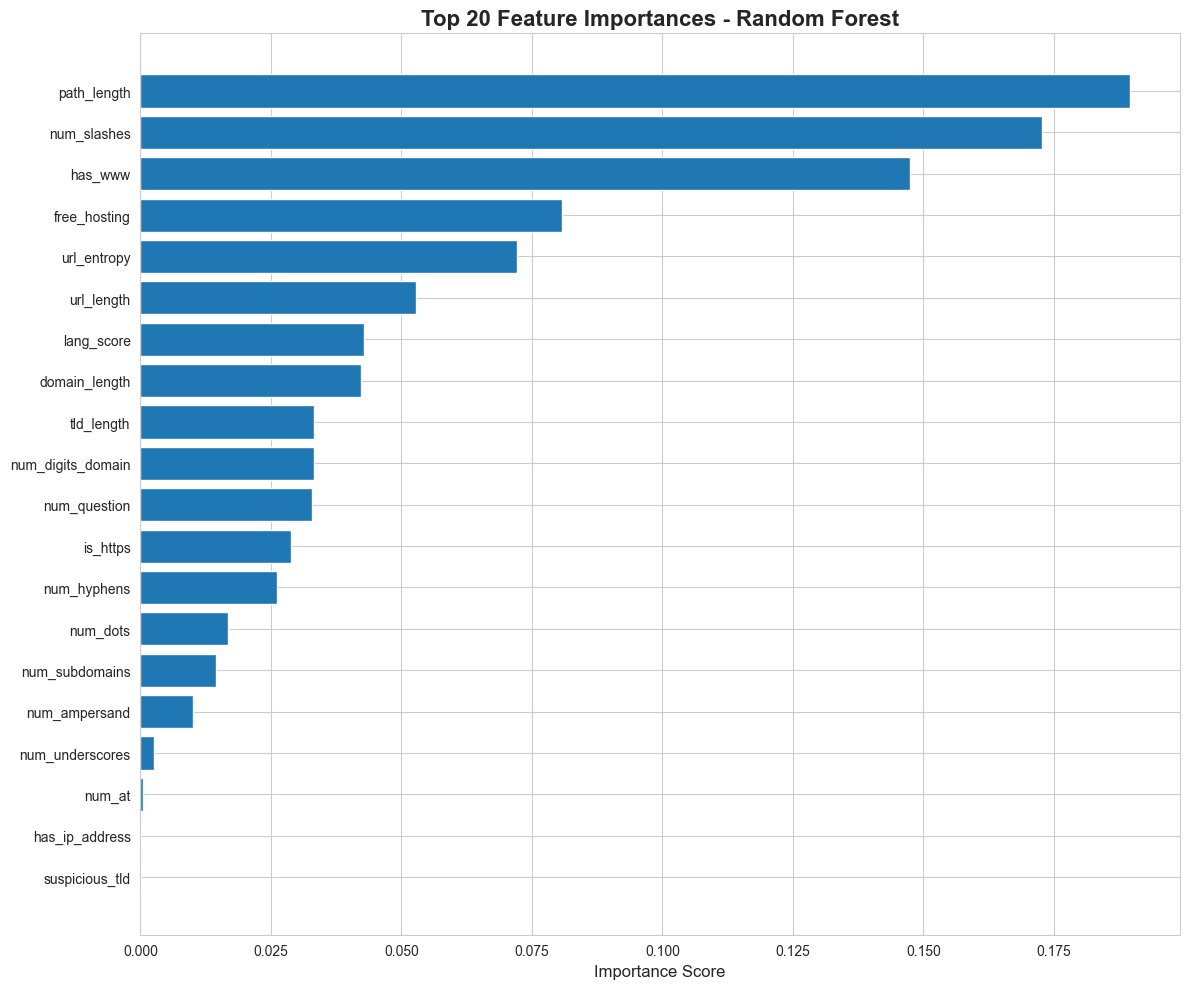


✅ Feature importance saved to: ../../../models/url-detection/rf_feature_importance.csv


In [ ]:
# ============================================
# STEP 9: FEATURE IMPORTANCE
# ============================================

print("FEATURE IMPORTANCE")


feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize top 20 features
plt.figure(figsize=(12, 10))
top_20_features = feature_importance.head(20)
plt.barh(range(len(top_20_features)), top_20_features['importance'])
plt.yticks(range(len(top_20_features)), top_20_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Feature Importances - Random Forest', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# STEP 10: SAVE MODEL
# ============================================

print("SAVING MODEL")

# Create models directory if it doesn't exist
model_dir = '../../../models/url-detection'
os.makedirs(model_dir, exist_ok=True)

# Save model
model_path = os.path.join(model_dir, 'random_forest.pkl')
print(f"\nSaving model to: {model_path}")

with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

print("Model saved successfully!")

# Save metrics
metrics = {
    'model': 'Random Forest',
    'train_accuracy': float(train_accuracy),
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'roc_auc': float(roc_auc),
    'training_time_seconds': float(training_time),
    'n_features': len(feature_names),
    'n_train_samples': len(y_train),
    'n_test_samples': len(y_test),
    'trained_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}


# Print file sizes
model_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
print(f"\nModel file size: {model_size:.2f} MB")


SAVING MODEL

💾 Saving model to: ../../../models/url-detection\random_forest.pkl
✅ Model saved successfully!
✅ Metrics saved to: ../../../models/url-detection\rf_metrics.csv

📦 Model file size: 73.49 MB


In [ ]:
# ============================================
# STEP 11: TEST LOADING MODEL (SANITY CHECK)
# ============================================

print("\n" + "="*60)
print("TESTING MODEL LOADING")
print("="*60)

# Load the model we just saved
print("\nLoading saved model...")
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

# Make a prediction with loaded model
print("Testing prediction with loaded model...")
sample_prediction = loaded_model.predict(X_test.head(5))
print(f"Sample predictions: {sample_prediction}")

print("Model loads and works correctly!")


TESTING MODEL LOADING

📥 Loading saved model...
🧪 Testing prediction with loaded model...
Sample predictions: ['benign' 'benign' 'benign' 'benign' 'benign']
✅ Model loads and works correctly!


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
